In [1]:
import os
from tqdm import tqdm
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.applications import resnet50
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Helper Functions

In [2]:
def maxProbability(arr):
    
    array=arr[0]
    max = array[0]
    for i in range(1,3):
        if array[i] > max:
            max = array[i]
    return max

In [3]:
def get_label(index):
    
    if index == 0:
        return 'AD'
    if index == 1:
        return 'CN'
    if index == 2:
        return 'MCI'

In [4]:
def max_of_two(prob1,prob2):
    
    if prob1 > prob2:
        return prob1
    return prob2

def max_of_three(prob1,prob2,prob3):
    
    return max_of_two(prob1, max_of_two(prob2,prob3))

# Data Path

In [5]:
#File of input, MRI Images
image_path_AD_Axial="../input/skullstrippedthreeviewsseparated/AD Axial"
image_path_AD_Coronal="../input/skullstrippedthreeviewsseparated/AD Coronal"
image_path_AD_Sagittal="../input/skullstrippedthreeviewsseparated/AD Sagittal"
image_path_CN_Axial="../input/skullstrippedthreeviewsseparated/CN Axial"
image_path_CN_Coronal="../input/skullstrippedthreeviewsseparated/CN Coronal"
image_path_CN_Sagittal="../input/skullstrippedthreeviewsseparated/CN Sagittal"
image_path_MCI_Axial="../input/skullstrippedthreeviewsseparated/MCI Axial"
image_path_MCI_Coronal="../input/skullstrippedthreeviewsseparated/MCI Coronal"
image_path_MCI_Sagittal="../input/skullstrippedthreeviewsseparated/MCI Sagittal"

# Append Images with their Correct Labels

In [6]:
def append_image_label(path,image_array,label_array,image_view):
    
    image_size=224
    
    for m in tqdm(os.listdir(path)):
        image=cv2.imread(os.path.join(path,m))
        image=cv2.resize(image,(image_size,image_size))
        image_array.append(image)
        label_array.append(image_view)
    
    return image_array,label_array

In [7]:
image_data_axial=[]
label_data_axial=[]
image_data_coronal=[]
label_data_coronal=[]
image_data_sagittal=[]
label_data_sagittal=[]

image_data_axial, label_data_axial = append_image_label(image_path_AD_Axial,image_data_axial,label_data_axial,'AD') 
image_data_coronal, label_data_coronal = append_image_label(image_path_AD_Coronal,image_data_coronal,label_data_coronal,'AD') 
image_data_sagittal, label_data_sagittal = append_image_label(image_path_AD_Sagittal,image_data_sagittal,label_data_sagittal,'AD') 

image_data_axial, label_data_axial = append_image_label(image_path_CN_Axial,image_data_axial,label_data_axial,'CN') 
image_data_coronal, label_data_coronal = append_image_label(image_path_CN_Coronal,image_data_coronal,label_data_coronal,'CN') 
image_data_sagittal, label_data_sagittal = append_image_label(image_path_CN_Sagittal,image_data_sagittal,label_data_sagittal,'CN')

image_data_axial, label_data_axial = append_image_label(image_path_MCI_Axial,image_data_axial,label_data_axial,'MCI') 
image_data_coronal, label_data_coronal = append_image_label(image_path_MCI_Coronal,image_data_coronal,label_data_coronal,'MCI') 
image_data_sagittal, label_data_sagittal = append_image_label(image_path_MCI_Sagittal,image_data_sagittal,label_data_sagittal,'MCI')   

100%|██████████| 101/101 [00:00<00:00, 111.73it/s]


In [8]:
image_data_axial= np.array(image_data_axial)
label_data_axial= np.array(label_data_axial)
image_data_coronal= np.array(image_data_coronal)
label_data_coronal= np.array(label_data_coronal)
image_data_sagittal= np.array(image_data_sagittal)
label_data_sagittal= np.array(label_data_sagittal)
    
unique_axial, inverse_axial = np.unique(label_data_axial, return_inverse=True)
onehot_axial = np.eye(unique_axial.shape[0])[inverse_axial] 

unique_coronal, inverse_coronal = np.unique(label_data_coronal, return_inverse=True)
onehot_coronal = np.eye(unique_coronal.shape[0])[inverse_coronal] 

unique_sagittal, inverse_sagittal = np.unique(label_data_sagittal, return_inverse=True)
onehot_sagittal = np.eye(unique_sagittal.shape[0])[inverse_sagittal]

# Split Images to Train and Validate

In [9]:
from sklearn.model_selection import train_test_split

train_X_axial,remainder_X_axial,train_Y_axial,remainder_Y_axial = train_test_split(image_data_axial,onehot_axial,test_size=0.2,stratify = onehot_axial,random_state=19)
valid_X_axial,test_X_axial,valid_Y_axial,test_Y_axial = train_test_split(remainder_X_axial,remainder_Y_axial, test_size=0.5,stratify = remainder_Y_axial,random_state=19)

train_X_coronal,remainder_X_coronal,train_Y_coronal,remainder_Y_coronal = train_test_split(image_data_coronal,onehot_coronal,test_size=0.2,stratify = onehot_coronal,random_state=19)
valid_X_coronal,test_X_coronal,valid_Y_coronal,test_Y_coronal = train_test_split(remainder_X_coronal,remainder_Y_coronal, test_size=0.5,stratify = remainder_Y_coronal,random_state=19)


train_X_sagittal,remainder_X_sagittal,train_Y_sagittal,remainder_Y_sagittal = train_test_split(image_data_sagittal,onehot_sagittal,test_size=0.2,stratify = onehot_sagittal,random_state=19)
valid_X_sagittal,test_X_sagittal,valid_Y_sagittal,test_Y_sagittal = train_test_split(remainder_X_sagittal,remainder_Y_sagittal, test_size=0.5,stratify = remainder_Y_sagittal,random_state=19)

#  Build Model

In [10]:
from tensorflow.keras.applications import resnet50

input_layer=layers.Input(shape=(224,224,3))
resnet_model=resnet50.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


# Customize Model

In [11]:
last_layer=resnet_model.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(3,activation='softmax')(flatten)
model=models.Model(inputs=input_layer,outputs=output_layer)

# Model Summary

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Plot Model

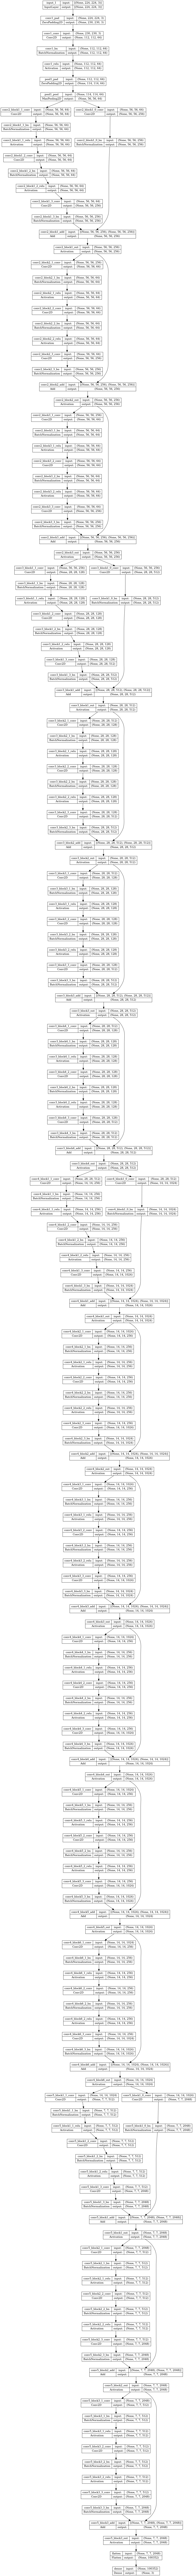

In [13]:
plot_model(model, to_file='cutomsized_resNet50.png', show_shapes=True, show_layer_names=True)

# Freeze all Layers Beside Last Layer

In [14]:
for layer in model.layers[:-1]:
    layer.trainable=False

# Compile Model

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

# Visualization of Training vs Validation Loss

In [16]:
def plot_loss(model_history,model_name):
    
    plt.figure()
    plt.plot(model_history.epoch, model_history.history['loss'], 'go', label='Training loss')
    plt.plot(model_history.epoch, model_history.history['val_loss'], 'g', label='Validation loss')
    if model_name == model_axial:
        plt.title('Training and Validation Loss of Axial Model')
    elif model_name == model_coronal:
        plt.title('Training and Validation Loss of Coronal Model')
    elif model_name == model_sagittal:
        plt.title('Training and Validation Loss of Sagittal Model')   
    plt.legend()
    plt.show()

# Visualization of Training vs Validation Accuracy

In [17]:
def plot_accuracy(model_history,model_name):
    
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    plt.figure()
    plt.plot(model_history.epoch, acc,'go', label='Training acc')
    plt.plot(model_history.epoch, val_acc, 'g', label='Validation acc')
    if model_name == model_axial:
        plt.title('Training and Validation Accuracy of Axial Model')
    elif model_name == model_coronal:
        plt.title('Training and Validation Accuracy of Coronal Model')
    elif model_name == model_sagittal:
        plt.title('Training and Validation Accuracy of Sagittal Model')   
    plt.legend()
    plt.show()
    acc = np.asarray(acc).mean()
    val_acc = np.asarray(val_acc).mean() 
    print('Mean training accuracy %f ' % acc)
    print('Mean validation accuracy %f' % val_acc)

# Train Model on Each View Separately

In [18]:
model_axial = 'training_axial/cp.ckpt'
model_coronal = 'training_coronal/cp.ckpt'
model_sagittal = 'training_sagittal/cp.ckpt'

In [19]:
def fit_model(training_set, training_labels,validation_set,validation_labels,model_file_name):
  
    history = model.fit(training_set,training_labels,epochs=20,batch_size=24,verbose=True,validation_data=(validation_set,validation_labels)
                     ,callbacks =[EarlyStopping(patience=6, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_acc', save_best_only=True, mode='max', period=1)])
    

    plot_loss(history,model_file_name)
    plot_accuracy(history,model_file_name)
    best_model = load_model(model_file_name)
    return best_model

Epoch 1/20
10/10 [==============================] - 59s 6s/step - loss: 24.0100 - acc: 0.3629 - val_loss: 32.7065 - val_acc: 0.4000
Epoch 2/20
10/10 [==============================] - 28s 3s/step - loss: 19.6656 - acc: 0.4430 - val_loss: 10.7247 - val_acc: 0.4000
Epoch 3/20
10/10 [==============================] - 54s 6s/step - loss: 6.1495 - acc: 0.6414 - val_loss: 6.3130 - val_acc: 0.5333
Epoch 4/20
10/10 [==============================] - 28s 3s/step - loss: 2.5179 - acc: 0.7637 - val_loss: 5.6784 - val_acc: 0.5000
Epoch 5/20
10/10 [==============================] - 58s 6s/step - loss: 1.5931 - acc: 0.8397 - val_loss: 3.1411 - val_acc: 0.6667
Epoch 6/20
10/10 [==============================] - 58s 6s/step - loss: 0.2457 - acc: 0.9451 - val_loss: 3.0759 - val_acc: 0.8000
Epoch 7/20
10/10 [==============================] - 29s 3s/step - loss: 0.1280 - acc: 0.9705 - val_loss: 2.7422 - val_acc: 0.7333
Epoch 8/20
10/10 [==============================] - 31s 3s/step - loss: 0.0553 - acc: 

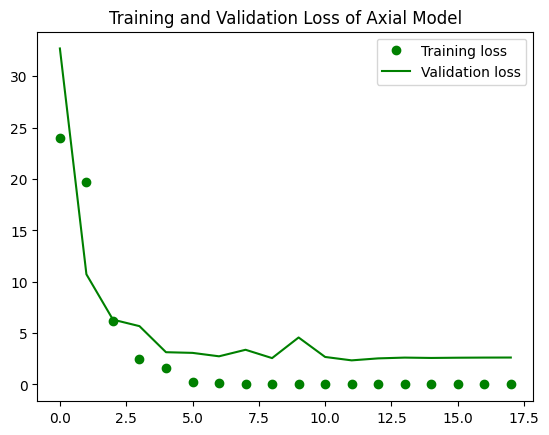

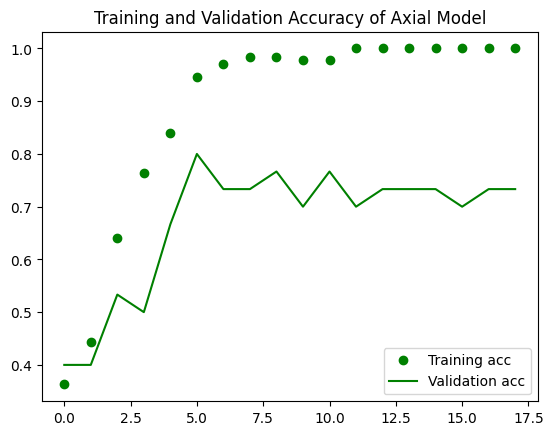

Mean training accuracy 0.882794 
Mean validation accuracy 0.670370
Epoch 1/20
10/10 [==============================] - 54s 6s/step - loss: 14.1086 - acc: 0.3840 - val_loss: 16.2304 - val_acc: 0.3667
Epoch 2/20
10/10 [==============================] - 56s 6s/step - loss: 12.7023 - acc: 0.5232 - val_loss: 13.8961 - val_acc: 0.4667
Epoch 3/20
10/10 [==============================] - 54s 6s/step - loss: 4.5297 - acc: 0.7215 - val_loss: 11.1386 - val_acc: 0.5000
Epoch 4/20
10/10 [==============================] - 54s 6s/step - loss: 1.4637 - acc: 0.8608 - val_loss: 9.4190 - val_acc: 0.5667
Epoch 5/20
10/10 [==============================] - 27s 3s/step - loss: 0.4965 - acc: 0.9578 - val_loss: 8.0874 - val_acc: 0.5333
Epoch 6/20
10/10 [==============================] - 29s 3s/step - loss: 0.1027 - acc: 0.9705 - val_loss: 8.0352 - val_acc: 0.5333
Epoch 7/20
10/10 [==============================] - 56s 6s/step - loss: 0.0124 - acc: 0.9958 - val_loss: 7.8153 - val_acc: 0.6000
Epoch 8/20
10/10 [

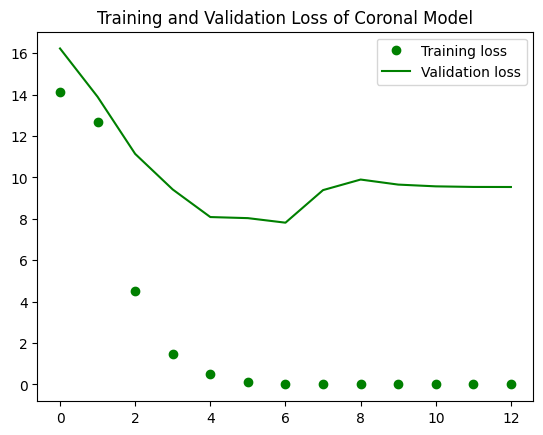

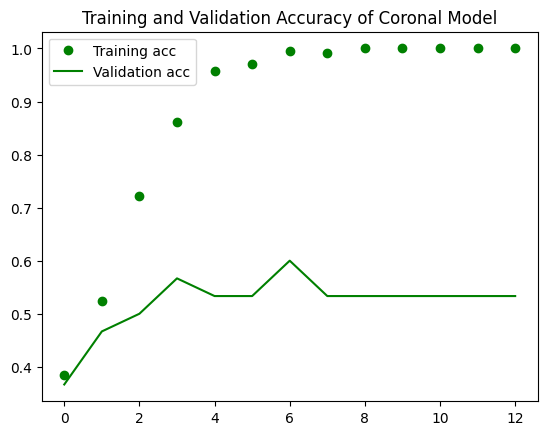

Mean training accuracy 0.877313 
Mean validation accuracy 0.520513
Epoch 1/20
10/10 [==============================] - 53s 6s/step - loss: 20.9226 - acc: 0.3460 - val_loss: 17.4656 - val_acc: 0.3333
Epoch 2/20
10/10 [==============================] - 54s 6s/step - loss: 15.2377 - acc: 0.5527 - val_loss: 9.2441 - val_acc: 0.5333
Epoch 3/20
10/10 [==============================] - 27s 3s/step - loss: 4.8505 - acc: 0.7426 - val_loss: 5.2785 - val_acc: 0.5000
Epoch 4/20
10/10 [==============================] - 55s 6s/step - loss: 2.1395 - acc: 0.8523 - val_loss: 11.2355 - val_acc: 0.6000
Epoch 5/20
10/10 [==============================] - 54s 6s/step - loss: 1.7815 - acc: 0.8734 - val_loss: 10.1935 - val_acc: 0.6667
Epoch 6/20
10/10 [==============================] - 27s 3s/step - loss: 0.9315 - acc: 0.9198 - val_loss: 7.6893 - val_acc: 0.5667
Epoch 7/20
10/10 [==============================] - 58s 6s/step - loss: 0.2194 - acc: 0.9536 - val_loss: 11.3511 - val_acc: 0.7000
Epoch 8/20
10/10 

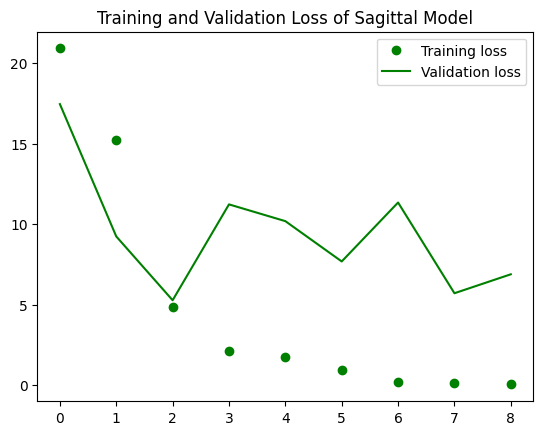

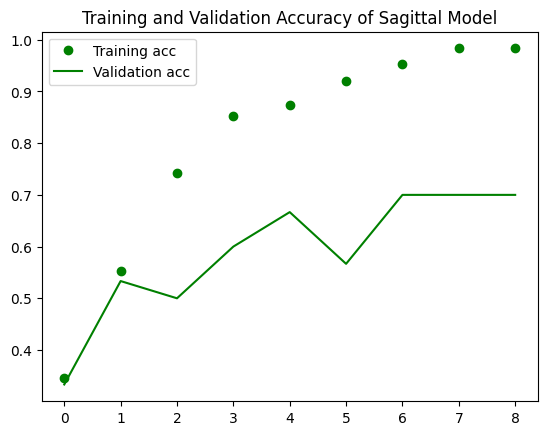

Mean training accuracy 0.800750 
Mean validation accuracy 0.588889


In [20]:
from tensorflow.keras.models import save_model

model_axial=fit_model(train_X_axial,train_Y_axial,valid_X_axial,valid_Y_axial,model_axial)

model_coronal=fit_model(train_X_coronal,train_Y_coronal,valid_X_coronal,valid_Y_coronal,model_coronal)
                   
model_sagittal=fit_model(train_X_sagittal,train_Y_sagittal,valid_X_sagittal,valid_Y_sagittal,model_sagittal)       

# Save Model

In [21]:
model_axial.save('/kaggle/working/model_axial.h5')
model_coronal.save('/kaggle/working/model_coronal.h5')
model_sagittal.save('/kaggle/working/model_sagittal.h5')

# Model Prediction and Check Upload

In [22]:
def get_pred_array(test_data,model_classifier_used):
    
    pred = model_classifier_used.predict(test_data)
    return pred

In [23]:
from sklearn.metrics import accuracy_score

def predict_label(test_data,test_label,image_view,isModel,model_classifier_used):
    
    pred_label = model_classifier_used.predict(test_data)
    
    if isModel:
        pred_label=np.argmax(pred_label,axis=1) 

    actual_label=np.argmax(test_label,axis=1)
    print("The "+ image_view +" accuracy score is",accuracy_score(actual_label, pred_label)*100)
    
    return pred_label,actual_label

In [24]:
pred_label_axial,actual_label_axial = predict_label(test_X_axial,test_Y_axial,'axial',True,model_axial)

pred_label_coronal,actual_label_coronal = predict_label(test_X_coronal,test_Y_coronal,'coronal',True,model_coronal)

pred_label_sagittal,actual_label_sagittal = predict_label(test_X_sagittal,test_Y_sagittal,'sagittal',True,model_sagittal)

1/1 [==============================] - 5s 5s/step
The axial accuracy score is 76.66666666666667
1/1 [==============================] - 4s 4s/step
The coronal accuracy score is 76.66666666666667
1/1 [==============================] - 4s 4s/step
The sagittal accuracy score is 66.66666666666666


In [25]:
axial_model_1 = load_model('/kaggle/working/model_axial.h5')
coronal_model_1 = load_model('/kaggle/working/model_coronal.h5')
sagittal_model_1 = load_model('/kaggle/working/model_sagittal.h5')

pred_label_axial_1,actual_label_axial_1 = predict_label(test_X_axial,test_Y_axial,'axial',True,axial_model_1)

pred_label_coronal_1,actual_label_coronal_1 = predict_label(test_X_coronal,test_Y_coronal,'coronal',True,coronal_model_1)

pred_label_sagittal_1,actual_label_sagittal_1 = predict_label(test_X_sagittal,test_Y_sagittal,'sagittal',True,sagittal_model_1)

1/1 [==============================] - 5s 5s/step
The axial accuracy score is 76.66666666666667
1/1 [==============================] - 5s 5s/step
The coronal accuracy score is 76.66666666666667
1/1 [==============================] - 4s 4s/step
The sagittal accuracy score is 66.66666666666666


# Model Confusion Matrix

In [26]:
label_name=["AD","CN","MCI"]

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(image_view,pred_label,actual_label):
    
    ConfusionMatrix = confusion_matrix(actual_label,pred_label)
    sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
    plt.title(image_view + " Confusion Matrix\n")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

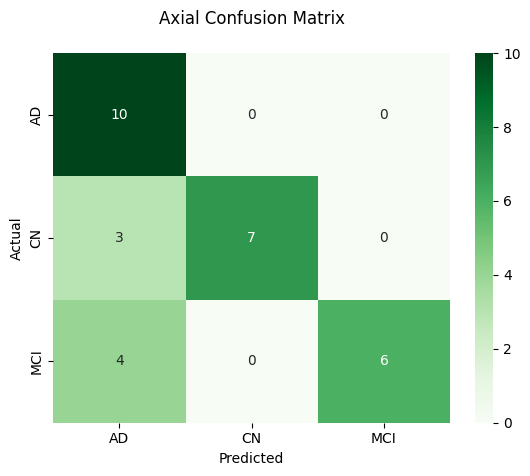

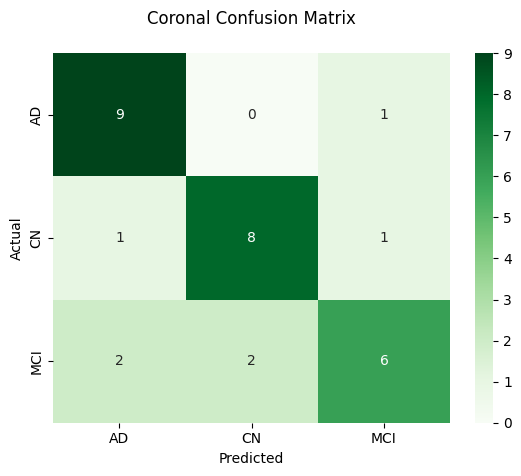

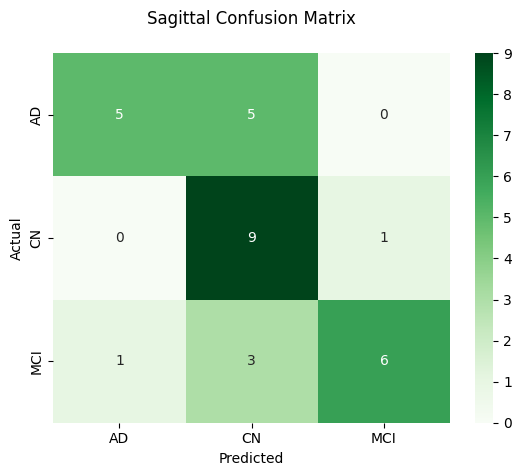

In [28]:
plot_confusion_matrix('Axial',pred_label_axial,actual_label_axial)
plot_confusion_matrix('Coronal',pred_label_coronal,actual_label_coronal)
plot_confusion_matrix('Sagittal',pred_label_sagittal,actual_label_sagittal)

# Model Classification Report

In [29]:
from sklearn.metrics import classification_report

def plot_classification_report(image_view, pred_label,actual_label):
    print("Classification Report of the "+ image_view+" Model\n")
    print(classification_report(actual_label,pred_label, target_names=["AD","CN","MCI"]))

In [30]:
plot_classification_report('Axial',pred_label_axial,actual_label_axial)
plot_classification_report('Coronal',pred_label_coronal,actual_label_coronal)
plot_classification_report('Sagittal',pred_label_sagittal,actual_label_sagittal)

Classification Report of the Axial Model

              precision    recall  f1-score   support

          AD       0.59      1.00      0.74        10
          CN       1.00      0.70      0.82        10
         MCI       1.00      0.60      0.75        10

    accuracy                           0.77        30
   macro avg       0.86      0.77      0.77        30
weighted avg       0.86      0.77      0.77        30

Classification Report of the Coronal Model

              precision    recall  f1-score   support

          AD       0.75      0.90      0.82        10
          CN       0.80      0.80      0.80        10
         MCI       0.75      0.60      0.67        10

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.76        30
weighted avg       0.77      0.77      0.76        30

Classification Report of the Sagittal Model

              precision    recall  f1-score   support

          AD       0.83      0.50      0.62        1

# Model ROC Curve

In [31]:
def helper_function_ROC_Curve(fpr,tpr,roc_auc,label,image_view):
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'g--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC Curve for " + label+" " +image_view+" Model")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

def plot_ROC_curve(data_view):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    if data_view == 'axial':
        pred_axial = get_pred_array(test_X_axial,model_axial)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(test_Y_axial[:, i], pred_axial[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(3):
            label = get_label(i)
            helper_function_ROC_Curve(fpr[i], tpr[i],roc_auc[i],label,'Axial')
           
            
    elif data_view == 'coronal':
        pred_coronal = get_pred_array(test_X_coronal,model_coronal)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(test_Y_coronal[:, i], pred_coronal[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(3):
            label = get_label(i)
            helper_function_ROC_Curve(fpr[i], tpr[i],roc_auc[i],label,'Coronal')
    
            
    elif data_view == 'sagittal':
        pred_sagittal = get_pred_array(test_X_sagittal,model_sagittal)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(test_Y_sagittal[:, i], pred_sagittal[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(3):
            label = get_label(i)
            helper_function_ROC_Curve(fpr[i], tpr[i],roc_auc[i],label,'Sagittal')

1/1 [==============================] - 3s 3s/step


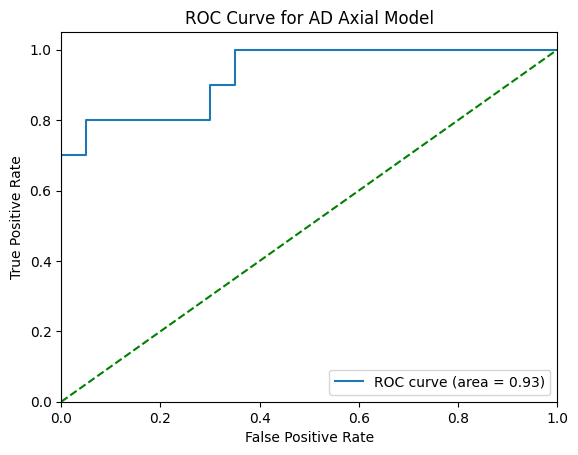

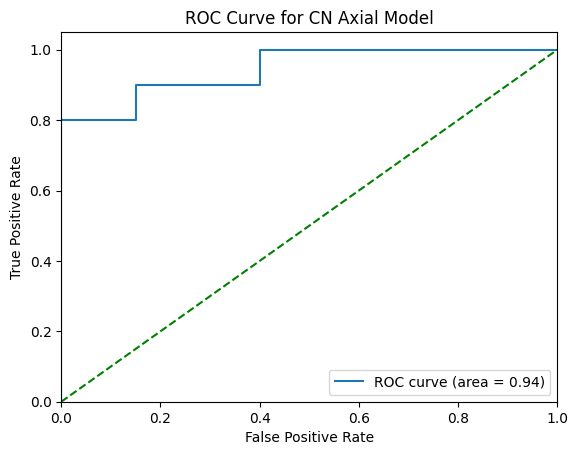

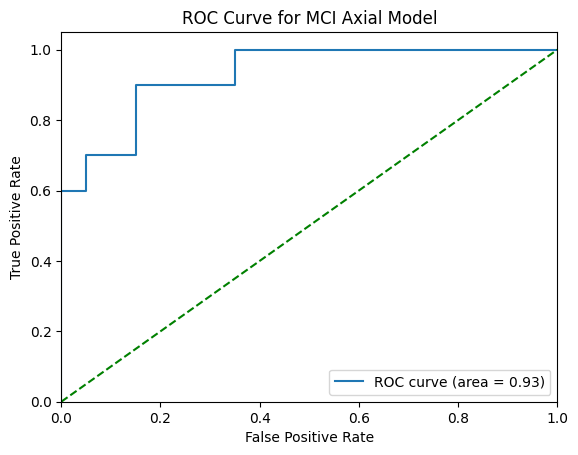

1/1 [==============================] - 3s 3s/step


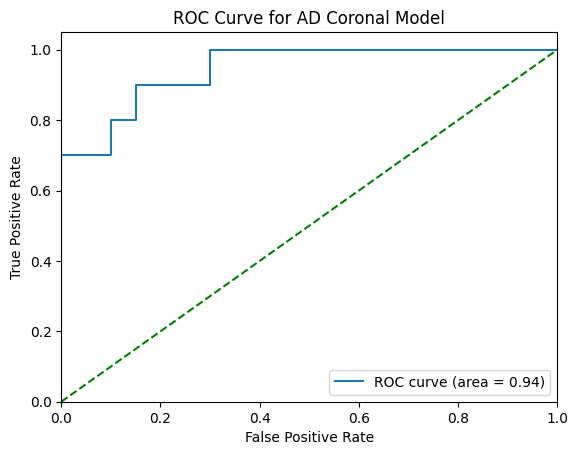

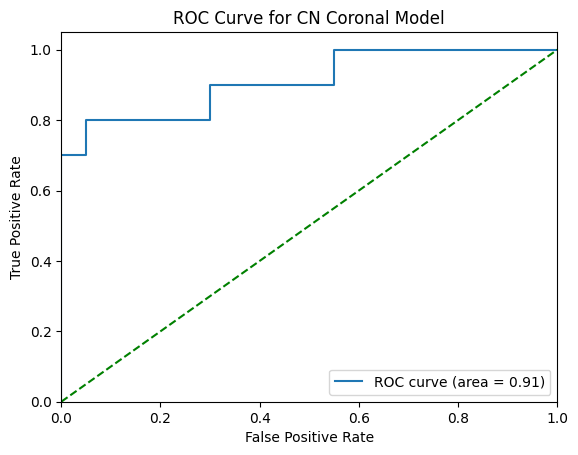

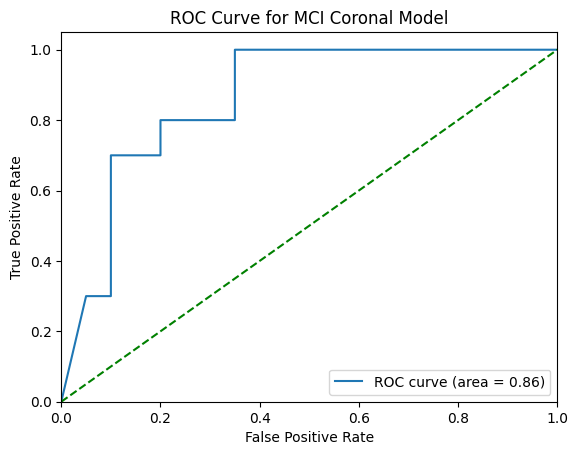

1/1 [==============================] - 3s 3s/step


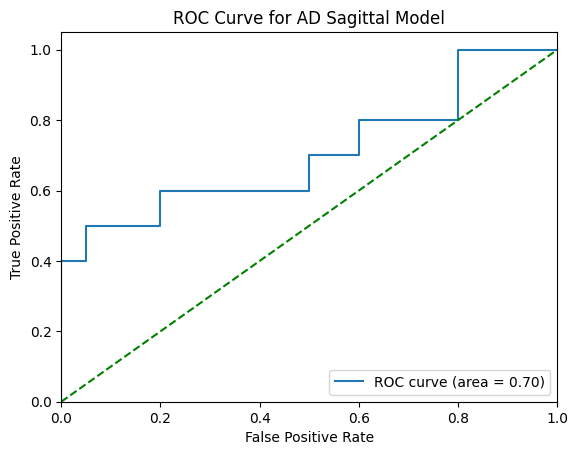

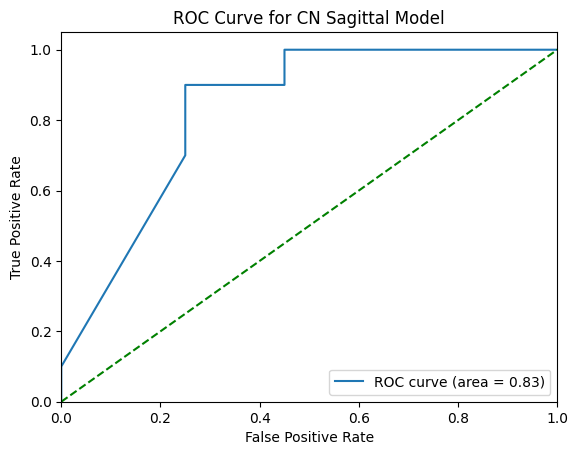

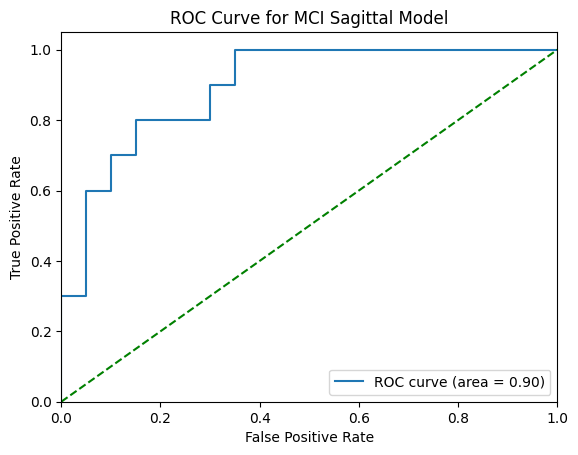

In [33]:
plot_ROC_curve('axial') 
plot_ROC_curve('coronal')
plot_ROC_curve('sagittal')

# Combine Three Models by Voting

In [34]:
def voting(pred_label,voting_list):
    
    if pred_label== 0:
         voting_list[0] += 1
    elif pred_label == 1:
         voting_list[1] += 1
    elif pred_label == 2:
         voting_list[2] += 1

In [35]:
predict_voting = []
for i in range (len(pred_label_axial)): 
    voting_list =[0, 0, 0]
    voting(pred_label_axial[i],voting_list)
    voting(pred_label_coronal[i],voting_list)
    voting(pred_label_sagittal[i],voting_list)
    predict_voting.append(np.argmax(voting_list))
    
print("The accuracy score of the combined models is",accuracy_score(actual_label_axial,np.array(predict_voting))*100)

The accuracy score of the combined models is 83.33333333333334


# Confusion Matrix of Combined Models

Text(0.5, 1.0, 'Combined Models Confusion Matrix\n')

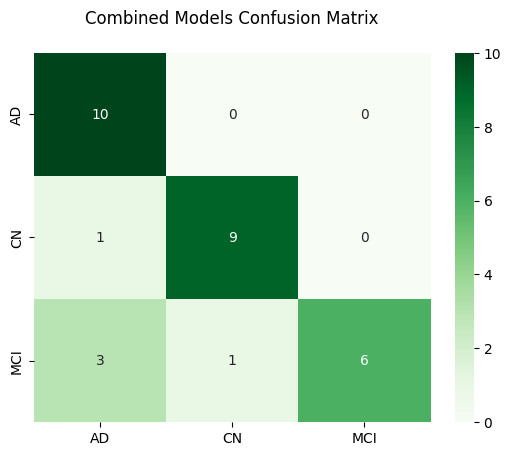

In [36]:
ConfusionMatrix = confusion_matrix(actual_label_axial,np.array(predict_voting))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Combined Models Confusion Matrix\n")

# Classification Report of Combined Models

In [37]:
print("Classification Report of the Combined Models\n")
print(classification_report(actual_label_axial,np.array(predict_voting), target_names=["AD","CN","MCI"]))

Classification Report of the Combined Models

              precision    recall  f1-score   support

          AD       0.71      1.00      0.83        10
          CN       0.90      0.90      0.90        10
         MCI       1.00      0.60      0.75        10

    accuracy                           0.83        30
   macro avg       0.87      0.83      0.83        30
weighted avg       0.87      0.83      0.83        30



# Combined Models Probabilities Testing

In [38]:
def test_case_one_image(view,image_view,isModel,model_used,classifier_used):
    
    plt.imshow(view, cmap='gray')
    plt.show()
    plt.axis('off')
    
    view = np.expand_dims(view, axis = 0)
    if isModel:
        result= model_used.predict(view)
        result_label=np.argmax(result,axis=1)
        probability= round((maxProbability(result)*100),2)
        print(probability, '% chances are there that the image is:',get_label(result_label[0]),'as predicted by '+image_view + ' model')
        
    else:
        model_result = model_used.predict(view)
        result_label= classifier_used.predict(model_result)
        probability= round((maxProbability(classifier_used.predict_proba(model_result))*100),2)
        print(probability, '% chances are there that the image is:',get_label(result_label[0]),'as predicted by ' +image_view + ' model followed by classifier')
             
            
    return result_label,probability

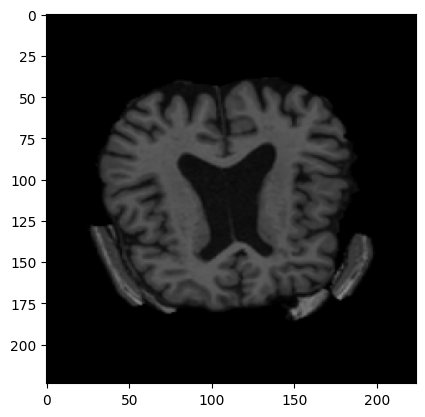

1/1 [==============================] - 0s 149ms/step
100.0 % chances are there that the image is: CN as predicted by axial model


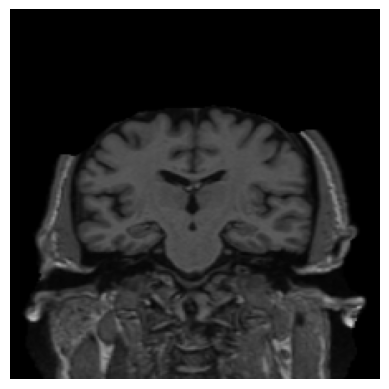

1/1 [==============================] - 0s 161ms/step
73.61 % chances are there that the image is: MCI as predicted by coronal model


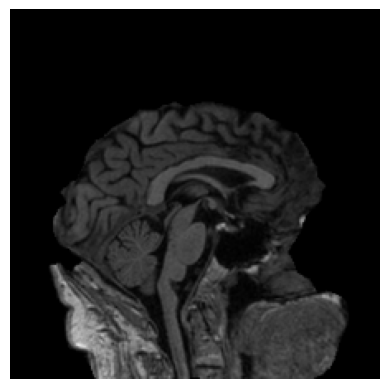

1/1 [==============================] - 0s 135ms/step
100.0 % chances are there that the image is: CN as predicted by sagittal model
[0, 2, 1]
The actual label is CN
100.0 % chances are there that the image is: CN as predicted by all models combined


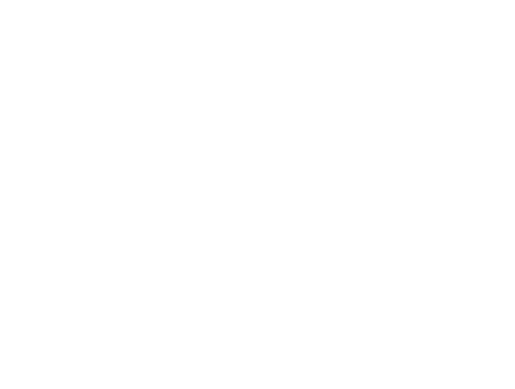

In [39]:
#TEST CASE
result_axial_label,probability_axial = test_case_one_image(test_X_axial[8],'axial',True,model_axial,None)
result_coronal_label,probability_coronal = test_case_one_image(test_X_coronal[8],'coronal',True,model_axial,None)
result_sagittal_label,probability_sagittal = test_case_one_image(test_X_sagittal[8],'sagittal',True,model_sagittal,None)

voting_list =[0, 0, 0]
voting(result_axial_label[0],voting_list)
voting(result_coronal_label[0],voting_list)
voting(result_sagittal_label[0],voting_list)
print(voting_list)
predict_voting = np.argmax(voting_list)
    

print('The actual label is',get_label(np.argmax(test_Y_axial,axis=1)[8]))
print(max_of_three(probability_axial,probability_coronal,probability_sagittal), '% chances are there that the image is:',get_label(predict_voting),'as predicted by all models combined')

# GradCam

In [40]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

In [41]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
   
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [42]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
  
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

Axial View GradCam


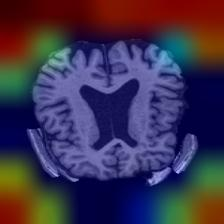

Coronal View GradCam


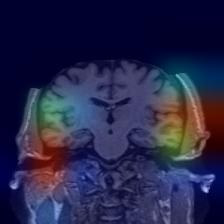

Sagittal View GradCam


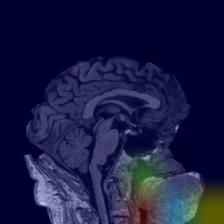

In [43]:
last_layer = "conv5_block3_3_conv"
image_axial = np.expand_dims(test_X_axial[8], axis = 0)
image_coronal = np.expand_dims(test_X_coronal[8], axis = 0)
image_sagittal = np.expand_dims(test_X_sagittal[8], axis = 0)

print("Axial View GradCam")
heatmap = make_gradcam_heatmap(image_axial,model_axial,last_layer)
save_and_display_gradcam(test_X_axial[8], heatmap)

print("Coronal View GradCam")
heatmap = make_gradcam_heatmap(image_coronal,model_coronal,last_layer)
save_and_display_gradcam(test_X_coronal[8], heatmap)

print("Sagittal View GradCam")
heatmap = make_gradcam_heatmap(image_sagittal,model_sagittal,last_layer)
save_and_display_gradcam(test_X_sagittal[8], heatmap)

# Extract Features

In [44]:
def extract_features_helper_function(image_view,train_data,valid_data,test_data):
    
    if image_view == 'axial':
        model_features = tf.keras.models.Model(inputs=model_axial.input,outputs=model_axial.get_layer('dense').output)
        
    elif image_view == 'coronal':
        model_features= tf.keras.models.Model(inputs=model_coronal.input,outputs=model_coronal.get_layer('dense').output)
           
    elif image_view == 'sagittal':
        model_features= tf.keras.models.Model(inputs=model_sagittal.input,outputs=model_sagittal.get_layer('dense').output)
    
    features_train= model_features.predict(train_data)
    features_validate= model_features.predict(valid_data)
    features_test= model_features.predict(test_data)
    
    return features_train, features_validate ,features_test, model_features 

In [45]:
#extract features from model trained on axial images
features_train_axial_2=[]
label_axial_2=[]
features_train_axial,features_validate_axial,features_test_axial,model_features_axial = extract_features_helper_function('axial',train_X_axial,valid_X_axial,test_X_axial)

for i in range(len(train_X_axial)):
    features_train_axial_2.append(features_train_axial[i])
    label_axial_2.append(train_Y_axial[i])

for i in range(len(valid_X_axial)):
    features_train_axial_2.append(features_validate_axial[i])
    label_axial_2.append(valid_Y_axial[i])
    
features_train_axial_2 = np.array(features_train_axial_2)
label_axial_2 = np.array(label_axial_2)


#extract features from model trained on coronal images
features_train_coronal_2=[]
label_coronal_2=[]
features_train_coronal,features_validate_coronal,features_test_coronal,model_features_coronal = extract_features_helper_function('coronal',train_X_coronal,valid_X_coronal,test_X_coronal)

for i in range(len(train_X_coronal)):
    features_train_coronal_2.append(features_train_coronal[i])
    label_coronal_2.append(train_Y_coronal[i])
      
for i in range(len(valid_X_coronal)):
    features_train_coronal_2.append(features_validate_coronal[i])
    label_coronal_2.append(valid_Y_coronal[i])
    
features_train_coronal_2 = np.array(features_train_coronal_2)
label_coronal_2 = np.array(label_coronal_2)


#extract features from model trained on sagittal images
features_train_sagittal_2=[]
label_sagittal_2=[]
features_train_sagittal,features_validate_sagittal,features_test_sagittal,model_features_sagittal = extract_features_helper_function('sagittal',train_X_sagittal,valid_X_sagittal,test_X_sagittal)

for i in range(len(train_X_sagittal)):
    features_train_sagittal_2.append(features_train_sagittal[i])
    label_sagittal_2.append(train_Y_sagittal[i])
    
for i in range(len(valid_X_sagittal)):
    features_train_sagittal_2.append(features_validate_sagittal[i])
    label_sagittal_2.append(valid_Y_sagittal[i])
    
features_train_sagittal_2 = np.array(features_train_sagittal_2)
label_sagittal_2 = np.array(label_sagittal_2)

1/1 [==============================] - 3s 3s/step


# XGBoost Classifier

In [46]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [47]:
def XGBoost (features_train,label,image_view):
    
    xb_KFold= KFold(n_splits=10,shuffle=True,random_state=3)
    xb_axial = xgb.XGBClassifier()
    hyperparameters= { 'min_child_weight': [1, 5],'gamma': [0.5, 1, 1.5],
                     'subsample': [0.8, 1.0],'colsample_bytree': [0.8, 1.0],
                      'max_depth': [4, 5]}
    bestModelFound = GridSearchCV(xb_axial,hyperparameters,cv=xb_KFold)
    bestModelFound.fit(features_train,np.argmax(label,axis=1))
    
    best_min_child_weight = bestModelFound.best_params_.get('min_child_weight')
    print("The best "+image_view+ " min_child_weight is:",best_min_child_weight)
    best_gamma = bestModelFound.best_params_.get('gamma')
    print("The best "+image_view+ " gamma is:",best_gamma)
    best_subsample = bestModelFound.best_params_.get('subsample')
    print("The best "+image_view+ " subsample is:",best_subsample)
    best_colsample_bytree = bestModelFound.best_params_.get('colsample_bytree')
    print("The best "+image_view+ " colsample_bytree is:",best_colsample_bytree)
    best_max_depth = bestModelFound.best_params_.get('max_depth')
    print("The best "+image_view+ " max_depth is:",best_max_depth)
    
    results= cross_val_score(xgb.XGBClassifier(min_child_weight = best_min_child_weight, gamma=best_gamma,
                                               subsample=best_subsample, colsample_bytree = best_colsample_bytree,
                                              max_depth = best_max_depth),features_train,np.argmax(label,axis=1),cv=10)
    print("The cross validation score of "+image_view+ " data is:",results)
    print("The accuracy of the "+image_view+ " data is :",results.mean()*100)   
    
    return  best_min_child_weight, best_gamma, best_subsample, best_colsample_bytree, best_max_depth 

In [48]:
best_axial_min_child_weight,best_axial_gamma,best_axial_subsample,best_axial_colsample_bytree, best_axial_max_depth = XGBoost(features_train_axial_2,label_axial_2,'axial')

best_coronal_min_child_weight,best_coronal_gamma,best_coronal_subsample,best_coronal_colsample_bytree, best_coronal_max_depth = XGBoost(features_train_coronal_2,label_coronal_2,'coronal')

best_sagittal_min_child_weight,best_sagittal_gamma,best_sagittal_subsample,best_sagittal_colsample_bytree, best_sagittal_max_depth = XGBoost(features_train_sagittal_2,label_sagittal_2,'sagittal')

The best axial min_child_weight is: 1
The best axial gamma is: 0.5
The best axial subsample is: 1.0
The best axial colsample_bytree is: 0.8
The best axial max_depth is: 5
The cross validation score of axial data is: [1.         0.96296296 0.96296296 1.         1.         1.
 1.         1.         0.88461538 0.76923077]
The accuracy of the axial data is : 95.79772079772081
The best coronal min_child_weight is: 5
The best coronal gamma is: 0.5
The best coronal subsample is: 1.0
The best coronal colsample_bytree is: 0.8
The best coronal max_depth is: 4
The cross validation score of coronal data is: [1.         1.         1.         1.         1.         1.
 0.96296296 1.         0.88461538 0.61538462]
The accuracy of the coronal data is : 94.62962962962962
The best sagittal min_child_weight is: 5
The best sagittal gamma is: 1.5
The best sagittal subsample is: 1.0
The best sagittal colsample_bytree is: 1.0
The best sagittal max_depth is: 4
The cross validation score of sagittal data is: [0

In [49]:
xb_axial = xgb.XGBClassifier(min_child_weight = best_axial_min_child_weight, gamma=best_axial_gamma,
                             subsample=best_axial_subsample, colsample_bytree = best_axial_colsample_bytree,
                             max_depth = best_axial_max_depth)
xb_axial.fit(features_train_axial_2,np.argmax(label_axial_2,axis=1))

xb_coronal = xgb.XGBClassifier(min_child_weight = best_coronal_min_child_weight, gamma=best_coronal_gamma,
                             subsample=best_coronal_subsample, colsample_bytree = best_coronal_colsample_bytree,
                             max_depth = best_coronal_max_depth)
xb_coronal.fit(features_train_coronal_2,np.argmax(label_coronal_2,axis=1))

xb_sagittal = xgb.XGBClassifier(min_child_weight = best_sagittal_min_child_weight, gamma=best_sagittal_gamma,
                             subsample=best_sagittal_subsample, colsample_bytree = best_sagittal_colsample_bytree,
                             max_depth = best_sagittal_max_depth)
xb_sagittal.fit(features_train_sagittal_2,np.argmax(label_sagittal_2,axis=1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# XGBoost Prediction

In [50]:
XGBoost_pred_axial_label,XGBoost_actual_axial_label = predict_label(features_test_axial,test_Y_axial,'axial',False,xb_axial)
XGBoost_pred_coronal_label,XGBoost_actual_coronal_label = predict_label(features_test_coronal,test_Y_coronal,'coronal',False,xb_coronal)
XGBoost_pred_sagittal_label,XGBoost_actual_sagittal_label = predict_label(features_test_sagittal,test_Y_sagittal,'sagittal',False,xb_sagittal)

The axial accuracy score is 83.33333333333334
The coronal accuracy score is 73.33333333333333
The sagittal accuracy score is 70.0


# XGBoost Confusion Matrix

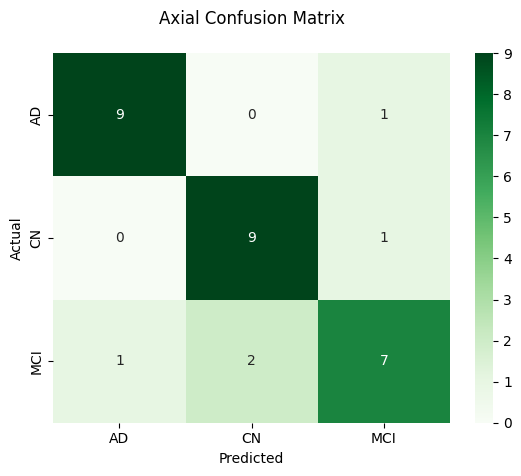

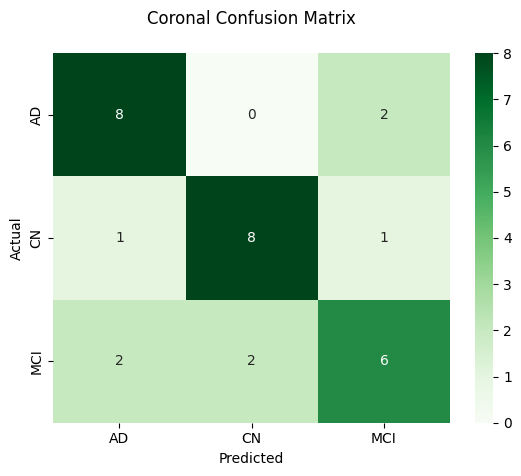

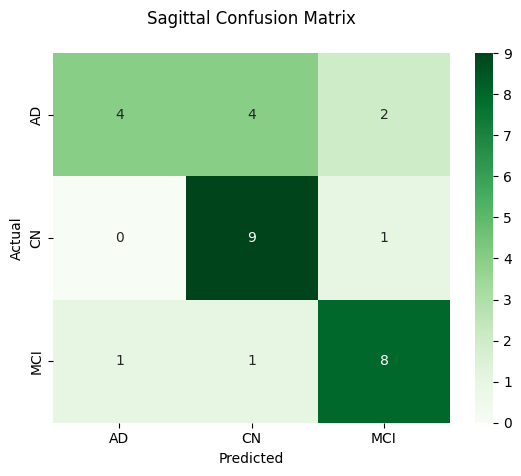

In [51]:
plot_confusion_matrix('Axial',XGBoost_pred_axial_label,XGBoost_actual_axial_label)
plot_confusion_matrix('Coronal',XGBoost_pred_coronal_label,XGBoost_actual_coronal_label)
plot_confusion_matrix('Sagittal',XGBoost_pred_sagittal_label,XGBoost_actual_sagittal_label)

# XGBoost Classification Report

In [52]:
plot_classification_report('Axial',XGBoost_pred_axial_label,XGBoost_actual_axial_label)
plot_classification_report('Coronal',XGBoost_pred_coronal_label,XGBoost_actual_coronal_label)
plot_classification_report('Sagittal',XGBoost_pred_sagittal_label,XGBoost_actual_sagittal_label)

Classification Report of the Axial Model

              precision    recall  f1-score   support

          AD       0.90      0.90      0.90        10
          CN       0.82      0.90      0.86        10
         MCI       0.78      0.70      0.74        10

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30

Classification Report of the Coronal Model

              precision    recall  f1-score   support

          AD       0.73      0.80      0.76        10
          CN       0.80      0.80      0.80        10
         MCI       0.67      0.60      0.63        10

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30

Classification Report of the Sagittal Model

              precision    recall  f1-score   support

          AD       0.80      0.40      0.53        1

# Combination of Three XGBoost Classifiers

In [53]:
def voting(pred_label,voting_list):
    
    if pred_label== 0:
         voting_list[0] += 1
    elif pred_label == 1:
         voting_list[1] += 1
    elif pred_label == 2:
         voting_list[2] += 1

In [54]:
predict_voting_XGBoost = []
for i in range (len(XGBoost_pred_axial_label)): 
    voting_list =[0, 0, 0]
    voting(XGBoost_pred_axial_label[i],voting_list)
    voting(XGBoost_pred_coronal_label[i],voting_list)
    voting(XGBoost_pred_sagittal_label[i],voting_list)
    predict_voting_XGBoost.append(np.argmax(voting_list))

print("The accuracy score of the combined classifiers is",accuracy_score(XGBoost_actual_axial_label,np.array(predict_voting_XGBoost))*100)

The accuracy score of the combined classifiers is 83.33333333333334


# Confusion Matrix of Combined XGBoost Classifiers

Text(0.5, 1.0, 'Confusion Matrix of the Combined XGBoost Classifiers \n')

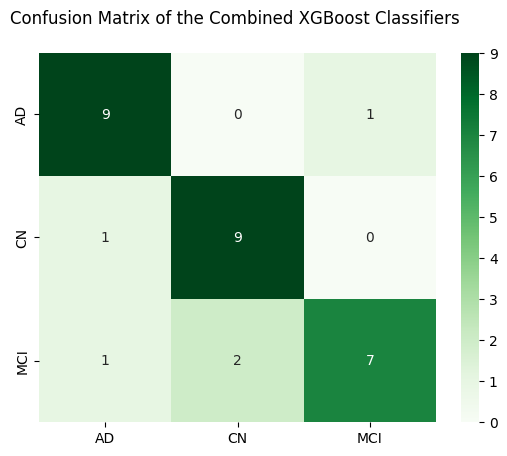

In [55]:
ConfusionMatrix = confusion_matrix(XGBoost_actual_axial_label,np.array(predict_voting_XGBoost))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix of the Combined XGBoost Classifiers \n")

# Classification Report of Combined XGBoost Classifiers

In [56]:
print("Classification Report of the Combined XGBoost Classifiers\n")
print(classification_report(XGBoost_actual_axial_label,np.array(predict_voting_XGBoost), target_names=["AD","CN","MCI"]))

Classification Report of the Combined XGBoost Classifiers

              precision    recall  f1-score   support

          AD       0.82      0.90      0.86        10
          CN       0.82      0.90      0.86        10
         MCI       0.88      0.70      0.78        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



# Combined XGBoost Probabilities Testing

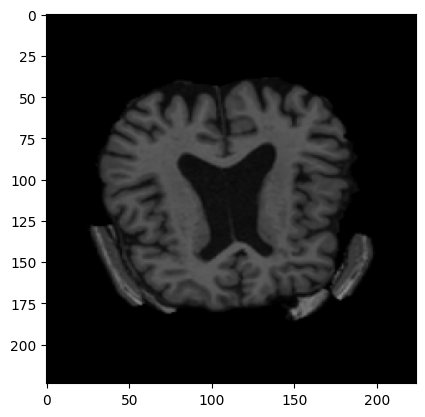

1/1 [==============================] - 0s 156ms/step
99.05 % chances are there that the image is: CN as predicted by axial model followed by classifier


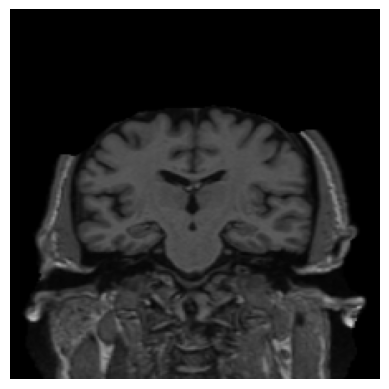

1/1 [==============================] - 0s 135ms/step
95.12 % chances are there that the image is: CN as predicted by coronal model followed by classifier


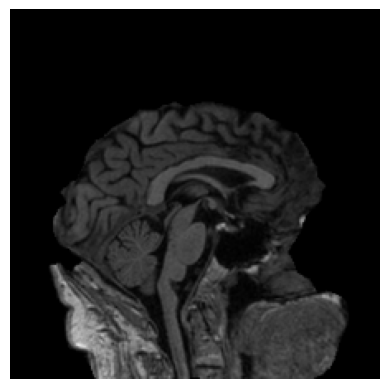

1/1 [==============================] - 0s 142ms/step
96.37 % chances are there that the image is: CN as predicted by sagittal model followed by classifier
The actual label is CN
99.05 % chances are there that the image is: CN as predicted by all models followed by XGBoost classifiers combined


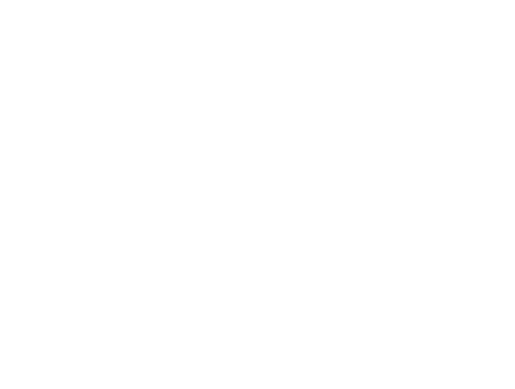

In [57]:
#TEST CASE
XGBoost_result_axial,probability_XGBoost_axial = test_case_one_image(test_X_axial[8],'axial',False,model_features_axial,xb_axial)
XGBoost_result_coronal,probability_XGBoost_coronal = test_case_one_image(test_X_coronal[8],'coronal',False,model_features_coronal,xb_coronal)
XGBoost_result_sagittal,probability_XGBoost_sagittal = test_case_one_image(test_X_sagittal[8],'sagittal',False,model_features_sagittal,xb_sagittal)

voting_list =[0, 0, 0]
voting(XGBoost_result_axial[0],voting_list)
voting(XGBoost_result_coronal[0],voting_list)
voting(XGBoost_result_sagittal[0],voting_list)
predict_voting = np.argmax(voting_list)
    
print('The actual label is',get_label(np.argmax(test_Y_axial,axis=1)[8]))
print(max_of_three(probability_XGBoost_axial,probability_XGBoost_coronal,probability_XGBoost_sagittal), '% chances are there that the image is:',get_label(predict_voting),'as predicted by all models followed by XGBoost classifiers combined')